In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
# Импортируем нужные библиотеки

#### Считывание и обработка данных

In [76]:
df = pd.read_excel("200_выпусков_'О_мой_питч!'_OutOfScope_update.xlsx", sheet_name='Лист2')
df = df.rename(columns={'Инвестиции' : 'Инвестиции(руб)', 'Без' : 'Воздержалось'})
df['За'] = pd.to_numeric(df['За'], errors='coerce')
df['Против'] = pd.to_numeric(df['Против'], errors='coerce')
df['Воздержалось'] = pd.to_numeric(df['Воздержалось'], errors='coerce')
df['Инвестиции(руб)'] = df['Инвестиции(руб)'].replace(0, np.nan)
df = df.drop(columns='№')
df = df.drop(index=82) #Дропаем строку в бизнесом, о котором нет данных
df = df.drop(index=176) #Дропаем строку в бизнесом, о котором нет данных
df = df.drop_duplicates(subset='Название')
pd.set_option('display.max_colwidth', None)  # 150 означает ограничение на кол-во символов в колонке "Описание"

#### Основные метрики по инвестициям и голосам в опросах

In [77]:
# Форматируем вывод чисел (два знака для float, целые для int)
pd.options.display.float_format = '{:,.2f}'.format
description = df[['Инвестиции(руб)', 'За', 'Против', 'Воздержалось', 'Всего']].describe()
description['Инвестиции(руб)'] = (description['Инвестиции(руб)'] / 1_000_000).round(2)
description[['За', 'Против', 'Воздержалось', 'Всего']] = description[['За', 'Против', 'Воздержалось', 'Всего']].astype(int)
description.rename(columns={'Инвестиции(руб)': 'Инвестиции (млн, руб)'}, inplace=True)
description_selected = description.loc[['mean', '25%', '50%', '75%', 'min', 'max']]
description_renamed = description_selected.rename(index={
    'mean': 'Среднее',
    '25%': '25-й перцентиль',
    '50%': 'Медиана (50-й перцентиль)',
    '75%': '75-й перцентиль',
    'min': 'Минимум',
    'max': 'Максимум'
})
description_renamed

,"Инвестиции (млн, руб)",За,Против,Воздержалось,Всего
Среднее,54.95,149,202,134,444
25-й перцентиль,11.81,95,132,101,357
Медиана (50-й перцентиль),27.00,128,175,131,435
75-й перцентиль,45.00,184,248,155,526
Минимум,0.08,35,43,61,182
Максимум,900.00,519,520,385,735


После пересмотра стартапов, где запрашиваемые инвестиции были 0, выяснилось, что на самом деле у таких стартапов просто нет информации по запрашиваемым инвестициям, поэтому все нули были заменены на NaN.  

### Разбивка стартапов по группам

In [78]:
keywords = {
    'Telegram' : ['телеграм', 'telegram', 'бот'],
    'Взаимоотношения' : [ 'познакомиться', 'знакомств', 'отношени', 'свидани', 'коммуникаци', 'скандал'],
    'AI_помощники' : ['виртуальн', 'помощник', 'ai', 'искусственн', 'интелект', 'ии', 'progpt','нейросет'], # proGPT нужен лишь для одного стартапа который относится к ИИ
    'Маркетинг_и_реклама' : ['реклам', 'маркетинг', 'продвижение', 'целевая аудитор', 'привлечен', 'конкурентный'],
    'B2B' : ['b2b', 'бизнес'],
    'Медицина' : ['профилактик', 'медицин', 'врач', 'докт', 'хирург ', 'маломобильных', 'процедур','здоровь', 'вирус', 'анализы', 'психолог', 'таблет', 'больн', 'узи', 'заболевани', 'фармацевт'],
    'Образование': ['студент', 'университет', 'школ', 'образован', 'универ', 'экзамен', 'общежит', 'образован', 'английск', 'иностранн', 'образовательн', 'school'],
    'Спорт': ['тренировк', 'фитнес', 'физкультур', 'атлетик', 'кардио', 'нагруз', 'сорев', 'экипиров', 'упражнен'],
    'Сервисы_доставки': [ 'курьер', 'доставк', 'груз', 'логистик', 'маршрут', 'навигатор'],
    'Путешествия': ['поездк', 'туризм', 'путешеств', 'путевк', 'экскурси', 'курорт', 'проживание', 'travel'],
    'Еда': ['кухн', 'повар', 'еда', 'пищ', 'рецепт', 'ингредиент', 'блюд', 'еды', 'общепит', 'едой', 'пончик'],
    'Автомобили_и_транспорт' : ['машина', 'техобслуж', 'кузов', 'транспорт','автомобил', 'двигател', 'автовладел', 'автозапчаст', 'машины'],
    'Финтех' : ['крипто', 'валюта', 'трейд', 'инвестици', 'блокчейн', 'страховани', 'кредит', 'банкинг', 'платежн'],
    'Маркетплейсы' : ['маркетплейс'],
    'Геймдев' : ['многопользовательск', 'игр'],
    'HR' : ['команду', 'специалист']
}
def categorize(description):
    matched_categories = []  # Список для хранения всех найденных категорий
    matched_words = {category: [] for category in keywords}  # Словарь для хранения всех ключевых слов по категориям
    words_in_description = description.lower().split()  # Разбиваем описание на слова
    
    for category, words in keywords.items():
        for word in words_in_description:
            for keyword in words:
                if word.startswith(keyword):
                    if keyword not in matched_words[category]:
                        matched_words[category].append(keyword)
                    if category not in matched_categories:
                        matched_categories.append(category)  # Добавляем категорию в список
    if not matched_categories:
        matched_categories.append('Прочее')
    return matched_categories, matched_words
    


def categorize_with_words(description):
    categories, words = categorize(description)  # Получаем список категорий и ключевые слова
    
    selected_categories = ', '.join(categories)  # Объединяем категории через запятую
    selected_keywords = ', '.join([', '.join(words.get(category, [])) for category in categories])  # Ключевые слова для всех категорий
    
    return pd.Series([selected_categories, selected_keywords])

df[['Категория', 'Ключевые слова']] = df['Описание'].apply(categorize_with_words)


Разбивка работает по принципу поиска ключевого слова (начала ключегого слова) в описании стартапа



#### Количество стартапов по категориям

In [79]:
def count_subcategory_occurrences(df, subcategories):
    categories = df['Категория'].str.split(', ', expand=True)
    categories = categories.melt(value_name='Категория').dropna()['Категория']
    results = []
    for subcategory in subcategories:
        count = categories[categories.str.contains(subcategory, case=True)].count()
        results.append((subcategory, count))
    result_df = pd.DataFrame(results, columns=['Категория', 'Количество'])
    result_df = result_df.sort_values(by='Количество', ascending=False).reset_index(drop=True)
    return result_df
subcategories_list = ['Прочее', 'Telegram', 'HR', 'B2B', 'Взаимоотношения', 'AI_помощники', 'Геймдев', 'Маркетплейсы', 'Финтех', 'Автомобили_и_транспорт', 'Медицина', 'Спорт', 'Сервисы_доставки', 'Путешествия', 'Еда', 'Образование', 'Маркетинг_и_реклама']
subcategory_counts_df = count_subcategory_occurrences(df, subcategories_list)
subcategory_counts_df

,Категория,Количество
0,Прочее,38
1,AI_помощники,37
2,B2B,25
3,Финтех,24
4,Медицина,21
5,Маркетинг_и_реклама,20
6,Сервисы_доставки,19
7,Маркетплейсы,17
8,Telegram,11
9,Автомобили_и_транспорт,11


#### Определение групп



- **Telegram** - к группе относятся стартапы, в которых основным продуктом является телеграм-бот либо сервис по работе с приложениями внутри телеграма

- **Взаимоотношения** - группа стартапов, в которых сосредоточены приложения для знакомств, семейные психологи  

- **AI_помощники** - стартапы с помощниками на искусственном интеллекте, которые выполняют самые разные задачи, от консультации по тренировкам до помощи в разработке приложений  

- **Маркетинг_и_реклама** - группа содержит стартапы, которые предоставляют различные услуги продвижения малым, средним, крупным бизнесам, а также стартапы, которые направлены на удовлетворение нужд и потребностей пользователей посредством обмена  
- **B2B** -  стартапы, которые помогают бизнесам развиваться (различные конструкторы, платформы и другое)  
- **Медицина** - различные девайсы для защиты здоровья, также имеются сервисы с AI, которые помогают врачам в разных областях проводить сложные операции  
- **Образование** - онлайн-школы, различные сервисы для студентов и школьников, сервисы по изучению иностранных языков 
- **Спорт** - приложения, которые составляют план тренировок, фитнес-трекеры
- **Сервисы_доставки** - сервисы/приложения/боты по доставке продуктов или вещей
- **Путешествия** - cтартапы из этой группы помогают найти дом, который будет наиболее подходящим, также есть сервисы для создания персонального плана путешествий  
- **Автомобили_и_транспорт** - в эту группу попали стартапы, которые нацелены на помощь водителям, механикам, и другим людям, которые работают в сфере транспорта
- **Финтех** - в группу входят стартапы по созданию криптовалютных кошельков, серсвисы трейдинга, блокчейн, платформы-помощники по получению кредита
- **Еда** - сервисы для помощи приготовления еды, поиска поваров, рецептов, доставки еды
- **Маркетплейсы** - группа содержит стартапы, главным продуктом которых является маркетплейс, либо "программа" (бот, AI), которая помогает работать с маркетплейсом  
- **Геймдев** - группа стартапов, в которых продуктом является игра/различные сервисы для игр  
- **HR** - стартапы из этой группы помогают найти команду/отдельных специалистов из разных сфер
- **Прочее** - в эту группу попали стартапы, которые не попали ни в одну из вышеперечисленных групп
   


#### Примеры случайных стартапов из каждой группы


In [87]:
def get_random_startup_by_category(df, columns_to_display, num_categories):
    random_startups = []
    grouped = df.groupby('Категория')  # Группировка по мультикатегориям
    
    # Случайный выбор категорий
    selected_categories = random.sample(list(grouped.groups.keys()), k=min(num_categories, len(grouped)))
    
    for category in selected_categories:
        group = grouped.get_group(category)  # Получаем группу для выбранной категории
        random_startup = group.sample(1)  # Выбираем случайный стартап для этой группы
        random_startups.append(random_startup)
        
    result_df = pd.concat(random_startups)
    return result_df[columns_to_display]

columns_to_display = ['Название', 'Описание', 'Категория', 'Ключевые слова']
random_startups_df = get_random_startup_by_category(df, columns_to_display, len(subcategory_counts_df))
random_startups_df

,Название,Описание,Категория,Ключевые слова
139,Bank of Мemories,"Команда Bank of Memories строит блокчейн с душой. Мы надежно сохраняем Ваши личные данные в умном хранилище, с функциями семейного древа, сообщений в будущее, унаследования информации через поколения с помощью цифрового завещания. Нет доступа третьих лиц к данным. Нет рекламы.","Маркетинг_и_реклама, Финтех","реклам, блокчейн"
189,КРК (Компания раскладных конструкций),"Ребята делают раскладные модули-прицепы, которые можно использовать для туризма, для торговли, в качестве строительных бытовок, постов охраны, для МЧС, МО и так далее. В них удобно жить, а поставить такой модуль-прицеп можно за 15 минут — фактически, просто запарковать. Инвестиции нужны на модернизацию производства.","Путешествия, Финтех","туризм, инвестици"
91,Ivitech,"Финтех-платформа, созданная для финансирования отраслей экономики, которые недофинансированы консервативной действующей финансовой системой (банки и другие классические финансовые инструменты). В основе платформы лежит уникальная скоринговая модель, основанная на анализе количественных и качественных показателей, свойственных конкретной отрасли, а не на классическом финансовом анализе, применяемом в банках. Текущая отрасль - таксопарки, также сейчас проходят тестовые сделки в отраслях логистики и поставщиков под маркетплейсы.","Сервисы_доставки, Маркетплейсы","логистик, маркетплейс"
158,Amai,"AI-generated actor’s voice for movies & audiobooks. We reduce the cost of voiceovers for films/audiobooks/games by a factor of 3-20 and increase the speed 100x by synthesizing high-quality voice with deep tuning of emotionality.\n\nА если по-русски, то чуваки научились синтезировать голос с помощью AI. И теперь их сервис позволяет заменять актеров при озвучивании аудиокниг, фильмов, игр, а еще можно заменять людей в колл-центрах. AI у них может даже с разными эмоциями говорить.","AI_помощники, Геймдев","ai, игр"
179,The World Community,"По сути, этот сервис — удалённый отдел продаж/партнерская сеть. Он помогает малому, среднему и крупному бизнесу привлекать клиентов с помощью партнёрской сети и удалённой работы менеджеров по продажам. Также сервис помогает привлекать рекламных партнеров, которые за вознаграждение (оплата за результат) готовы осуществлять интернет-маркетинг. Компании платят не за “клики”, а за состоявшиеся продажи товаров и услуг.","Маркетинг_и_реклама, B2B","реклам, бизнес"
151,Postoplan,"Глобальная система маркетинга в соцсетях и мессенджерах, с помощью которой вы можете регулярно и массово делать размещение контента и общаться с клиентами. Первые на этом рынке и вообще в мире сделали постинг в WhatsApp и темы оформления, сервис работает на 10 языках, клиенты из 140 стран мира. Входит в ТОП 5 самых перспективных стартапов в Эстонии.",Маркетинг_и_реклама,маркетинг
118,B2B-Export,"B2B-Export.com - cloud-платформа для управления кросс-граничной торговлей с Россией для МСБ. Наша команда занимается инновациями в области международной торговли между Россией и развивающимися рынками Азии, Африки, Латинской Америки с 2017 года, мы развиваем 4 программы по экспорту из России и импорту в Россию в b2b-формате (выручка в 2020 году - $700000).\n\nВ 2019 году мы привлекли первый раунд инвестиций, расширили географию и количество программ в экспорте, запустили FoodTech-платформу по оптовой торговле продовольствием между Россией и МСП из развивающихся стран. Подошли к стадии А и ожидаем рост выручки до $3,2 млн в 4 программах в 2022 году. Для масштабирования успешных программ и расширения географии мы привлекаем инвестиции в размере $950000, уже получили первый транш от частного инвестора на $200000.","B2B, Финтех","b2b, инвестици"
197,Azura AI,"Azura AI разрабатывает сервис для поддержания и профилактики здоровья, который:\n— хранит и автоматически собирает медицинские данные пользователя, в том числе и с фитнес-трекеров,\n— предоставляет персональные рекомендации по улучшению здоровья,\n— предсказывает вероятности возникновения заболеваний.

#### Количество стартапов в отдельно выбранной категории

In [81]:
df[df['Категория'].str.contains('HR', na=False)]


,Название,Описание,Сайт,Инвестиции(руб),За,Против,Воздержалось,Всего,Дата,Категория,Ключевые слова
13,Дом без забот,"«Дом без забот» - это сервис, который связывает специалистов (сантехников, электриков, сборщиков мебели и так далее) с их клиентами. Проект за 4 года работы уже показал высокий спрос со стороны потребителей. Сейчас на сервисе 275 000 специалистов по всей России",https://dombezzabot.info/,"50,000,000.00",235,146,164.00,545,2024-03-14,HR,специалист
25,Brainbox.vc,"Brainbox.VC – краудинвестинговая платформа в РФ (лицензия Банка России №77). Строим площадку, на которой IT-стартапы на ранней стадии смогут найти (1) инвесторов, (2) специалистов. Саму платформу развивает сообщество brainbox.team и сейчас мы ищем новых участников сообщества, которые готовы финансировать проект, купив его акции.",https://brainbox.vc/,"50,000,000.00",136,246,186.00,568,2023-11-23,HR,специалист
79,Kwikwins,"Платформа формирования компетенций по запросу и управления циклом создания цифрового продукта. Если нужно быстро собрать проверенную продуктовую команду с опытным тимлидом, то Kwikwins закроет эту проблему для фаундеров",https://kwikwins.io/,NaN,107,159,189.00,455,2022-08-11,HR,команду
197,Azura AI,"Azura AI разрабатывает сервис для поддержания и профилактики здоровья, который:\n— хранит и автоматически собирает медицинские данные пользователя, в том числе и с фитнес-трекеров,\n— предоставляет персональные рекомендации по улучшению здоровья,\n— предсказывает вероятности возникновения заболеваний.\n\nРабота сервиса основана на применении искусственного интеллекта. В команде Azure AI есть и специалисты по ИИ, и врачи.",http://bit.ly/2ms6Nrg,"13,500,000.00",125,105,NaN,230,2019-09-21,"AI_помощники, Медицина, Спорт, HR","ai, искусственн, ии, профилактик, здоровь, медицин, заболевани, врач, фитнес, специалист"


#### Визуализируем данные

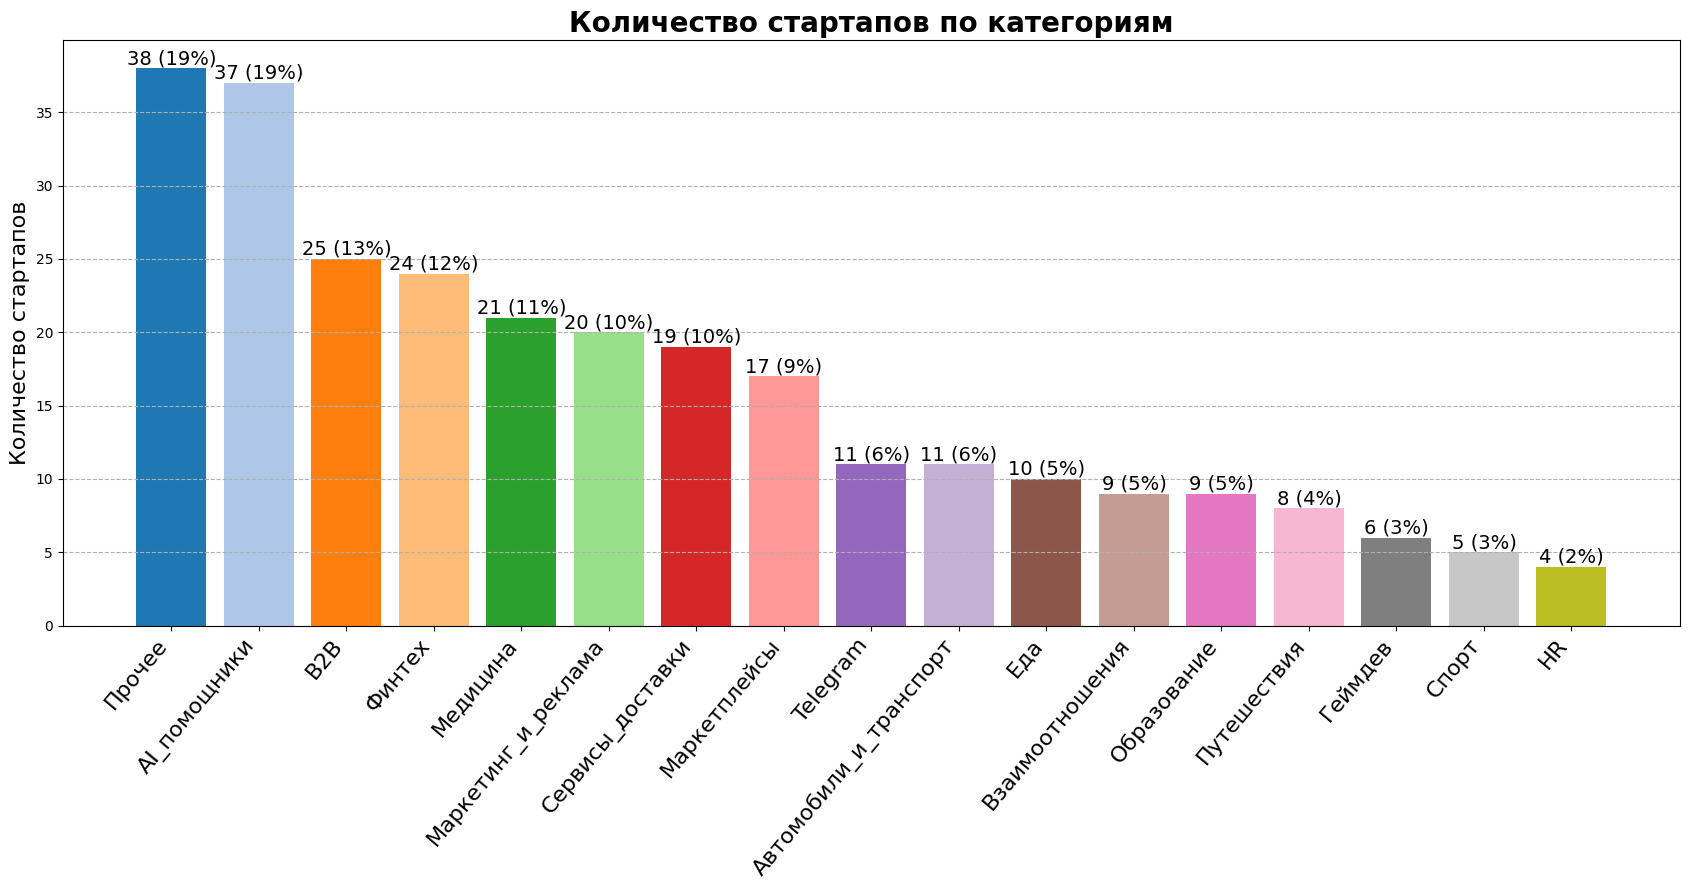

In [82]:
category_labels = subcategory_counts_df['Категория']
category_counts = subcategory_counts_df['Количество']
colors = plt.get_cmap('tab20').colors
total_counts = df.shape[0]
plt.figure(figsize=(17, 9))
bars = plt.bar(
    category_labels, 
    category_counts, 
    color=colors[:len(category_labels)]
)
plt.title('Количество стартапов по категориям', fontsize=20, fontweight='bold')
plt.ylabel('Количество стартапов', fontsize=16)
plt.xticks(rotation=50, fontsize=16, ha='right')  # Поворот меток категорий, если они длинные
plt.grid(axis='y', linestyle='--')  # Сетка по вертикальной оси
plt.tight_layout()  # Подгонка для отображения меток
for bar, count in zip(bars, category_counts):
    height = bar.get_height()
    # Рассчитываем процент
    percent = count / total_counts * 100
    # Отображаем количество и процент на графике
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height, 
        f'{count} ({percent:.0f}%)', 
        ha='center', 
        va='bottom', 
        fontsize=14
    )
plt.show()



Видим, что распределение по заданным (предполагаемым) группам в основном сосредоточилось на маркетинге, рекламе и AI помощниках.

Это может быть связано с тем, что в настоящее время цифровые технологии применяются в любой области, что потверждается данными из массива уникальных подгрупп, почти в каждой из которых есть либо маркетинг с рекламой, либо AI

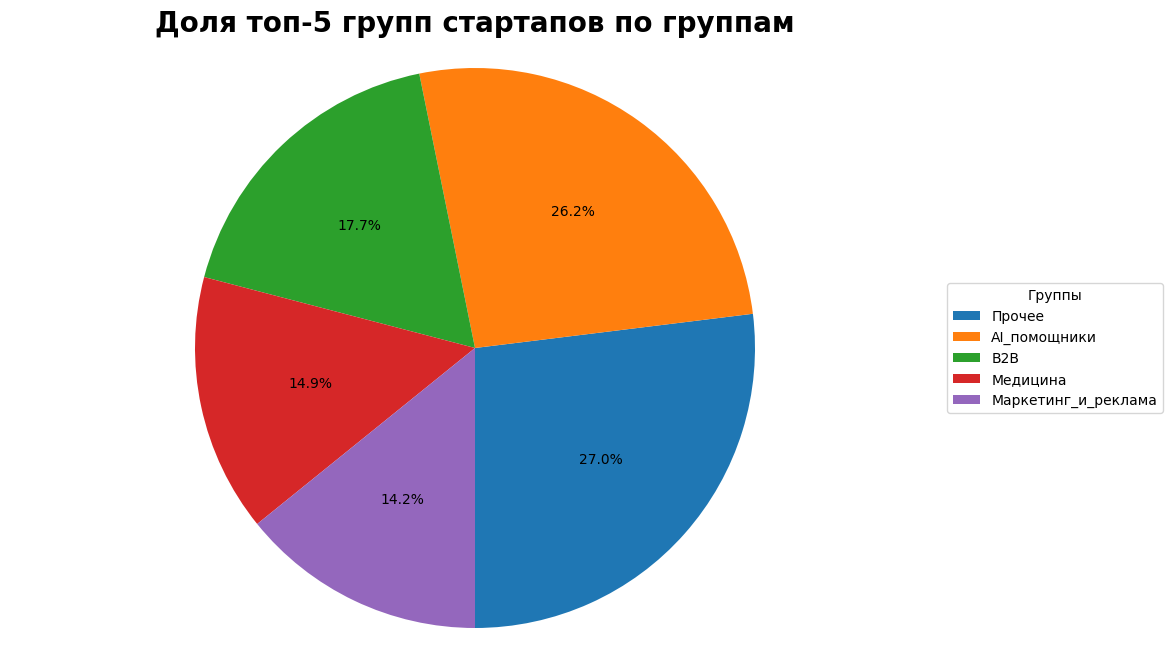

In [83]:
# Список категорий, которые нужно отобразить
categories_to_display = ['AI_помощники', 'B2B', 'Медицина', 'Маркетинг_и_реклама', 'Прочее']  # Замените на нужные категории

# Получаем категории и количество из DataFrame (как Series)
category_labels = subcategory_counts_df['Категория']
category_counts = subcategory_counts_df['Количество']

# Фильтруем данные по категориям, которые нужно отобразить
filtered_df = subcategory_counts_df[subcategory_counts_df['Категория'].isin(categories_to_display)]

# Обновляем переменные с отфильтрованными данными
filtered_labels = filtered_df['Категория']
filtered_counts = filtered_df['Количество']

# Настраиваем цвета для диаграммы
colors = plt.get_cmap('tab10').colors

# Создаём диаграмму
plt.figure(figsize=(12, 8))
plt.pie(
    filtered_counts,
    autopct='%1.1f%%',
    colors=colors[:len(filtered_labels)],
    startangle=-90
)

# Добавляем легенду и настраиваем оформление
plt.legend(
    filtered_labels,
    title="Группы",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Доля топ-5 групп стартапов по группам', fontsize=20, fontweight='bold')
plt.axis('equal')  # Оформление диаграммы в круг
plt.show()


Самая крупная группа — "Прочее", которая занимает 32.8% топ-5 стартапов. Это может означать, что значительное количество стартапов не попало в четко определенные категории. Стартапы из категории "Прочее" можно посмотреть ниже  

AI помощники занимают второе место с долей 29.3%. Это может быть связано с тем, что в современном мире все больше и больше повсеместно внедряюся AI технологии

Группа B2B составляет 13.8% стартапов, тем самам ненамного отрывается от Маркетинга и Медицины  

Маркетинг и реклама и Медицина имеют одинаковую долю по 12.1%. Это неожиданный результат. Можно предположить, что в наше время стартапы по медицине привлекают не меньший интерес, чем стартапы по маркетингу  
 
Таким образом, стартапы, связанные с искусственным интеллектом и B2B, занимают значительную долю в экосистеме, однако большая часть проектов остается неотнесенной к конкретным категориям и попадает в категорию "Прочее".


#### Стартапы из группы "Прочее"

In [84]:
df[df['Категория'].str.contains('Прочее', na=False)]


,Название,Описание,Сайт,Инвестиции(руб),За,Против,Воздержалось,Всего,Дата,Категория,Ключевые слова
14,Dialext,"Dialext — сервис, который позволяет увеличивать конверсию в продажи за счет автоматического аудита телефонных переговоров. Он позволяет выявить и исправить ошибки ваших продажников",https://dialext.com/,"6,000,000.00",106,113,125.00,344,2024-02-22,Прочее,
20,SmartAim,"SmartAim — система визуального поиска,\nадресной регистрации и навигации объектов для складов. Она помогает кладовщику с быстрым поиском необходимого адреса. Сотрудник склада безошибочно, по подсказке - световому лучу, двигается к нужному месту на складе, не смотря в монитор ТСД или визуально сверяясь с множеством меток адресного хранения.",-,"20,000,000.00",97,98,137.00,332,2023-12-28,Прочее,
24,Advengene,"Advengene - поиск подтверждения национальности предков для получения гражданства Израиля, Германии, Польши, Латвии, Эстонии, Литвы, Финляндии по репатриации",https://advengene.com/,NaN,124,182,177.00,483,2023-11-30,Прочее,
26,ieye,"ieye — приложение, которое позволяет быстро и точно находить нужные заведения (бары, рестораны, ночные клубы и так далее). При этом можно узнать, сколько там посетителей, есть ли там друзья и знакомые, какие скидки и предложения действуют",http://ieye.io/,"180,000,000.00",95,330,176.00,601,2023-11-16,Прочее,
31,TapTable,"Tap Table — это легкое и быстрое приложение для онлайн-бронирования столиков в кафе, ресторанах и барах, а также удобная админ-панель для ресторана. Сейчас мы запустились в трех городах Краснодарского края ( Краснодар, Сочи, Геленджик). Только в Краснодаре с июня к сервису подключились 50 ресторанов. Мы бур",https://taptable.ru/,"36,000,000.00",117,245,132.00,494,2023-10-12,Прочее,
32,Paraliq,Инфраструктура и White Label решения для создания децентрализованных казино в один клик,http://paraliq.com/,"90,000,000.00",117,178,113.00,408,2023-09-28,Прочее,
34,Liberty Card,Сервис дистанционного оформления зарубежных карт Visa и Mastercard,https://libertycard.ru/,"500,000.00",129,203,125.00,457,2023-09-14,Прочее,
40,Вручалка,"Вручалка — сервис заказа подарков и услуг торжественного вручения. Через него можно выбрать, а затем вручить подарок друзьям, родственникам или знакомым в другом городе или стране. Сервис запустили в 2021-м, а сейчас развивают франшизу и собираются выходить на международный рынок.",https://vruchalka.com/,"50,000,000.00",84,232,135.00,451,2023-07-27,Прочее,
41,Directual,No-code для сложных web и web3 приложений,https://www.directual.com/,"90,000,000.00",82,125,96.00,303,2023-07-20,Прочее,
44,Waggy.pro,"Сервис консультаций для владельцев собак. Кинологи помогут выбрать щенка, сделать первые месяцы комфортными и счастливыми, исправить поведенческие проблемы. Сейчас сервис работает как агрегатор, но начал тестировать подписку",https://waggy.pro/,NaN,98,130,103.00,331,2023-06-22,Прочее,
